# Funkcje Pomocnicze do Zadania

Aby wszystkie funkcje zadziałały, notebook powinien być uruchamiany z następującym ułożeniem katalogów:

```
|- helpers.ipynb
|- sampleSubmission.csv
|- train
 |- {unzipped train files and labels}
|- test
 |- {unzipped test files}
```

Należy odkomentować u siebie linijki zapisujące pliki.

In [5]:
!conda install -c conda-forge -y librosa

Solving environment: - ^C
failed

CondaError: KeyboardInterrupt



In [1]:
import os

import librosa
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm, trange

# Wczytywanie Danych

Poniższe funkcje są przykładowymi funkcjami wczytującymi dane. Możliwe, że będą potrzebne modyfikacje reprezentacji i bardziej skomplikowana funkcja tworząca zbiór treningowy. Wczytywanie danych nie jest zaimplementowane optymalnie - między innymi kod wczytuje wielokrotnie ten sam plik. Dla bardziej złożonych reprezentacji możliwe, że trzeba będzie przepisać te funkcje.

In [774]:
def load_mel(file_name, start=0, stop=None, n_mels=10):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, sample_rate = librosa.core.load(file_name, sr = None)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                 n_mels = n_mels, fmin = 6000, fmax = 8500)
#     spectrogram = stats.boxcox(spectrogram, lmbda=0.043, alpha=0.000001)

    mfccs = librosa.feature.mfcc(S=spectrogram, norm='ortho', dct_type=3)
    return mfccs
#     return spectrogram


def load_spec(file_name, start=0, stop=None):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate, samples = wavfile.read(file_name)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    _, _, spectrogram = signal.spectrogram(samples, sample_rate)
    return spectrogram


def load_test(load_repr=load_mel):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    with open('sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = [file_name for file_name in os.listdir('test') if file_name.endswith('.wav')]
    for file_name in rec_files:
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            representation = load_repr(os.path.join('test', file_name), start = t, stop = t + 1)
            X_test.append(representation)
    return np.array(X_test)


def read_labels():
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join('train', 'labels.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[1:]:
            if len(line) > 1:
                rec, start, stop = line.split(',')
                rec, start, stop = int(rec[3:]), float(start), float(stop)
                labels.append([rec, start, stop])
    return np.array(labels)


def check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    '''
    return (labels[1] >= second and labels[1] < second + 1 - tol) or \
           (labels[2] < second + 1 and labels[2] > second + tol) or \
           (labels[1] < second and labels[2] > second + 1)


def map_seconds_to_y(labels):
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    y = [0] * 10
    y_restrictive = [0] * 10
    for s in range(10):
        for l in labels:
            if check_voices(s, l):
                y[s] = 1
            if check_voices(s, l, 0.02):
                y_restrictive[s] = 1
        if y[s] != y_restrictive[s]:
            y[s] = -1
    return y


def load_train(load_repr=load_mel):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    labels = read_labels()
    X_train, y_train = [], []
    rec_files = [file_name for file_name in os.listdir('train') if file_name.endswith('.wav')]
    print(rec_files)
    for file_name in rec_files:
        recording_id = int(file_name.split('.')[0][3:])
        recording_labels = labels[labels[:, 0] == recording_id]
        y_binary = map_seconds_to_y(recording_labels)
        for i, y in enumerate(y_binary):
            if y != -1:
                try:
                    representation = load_repr(os.path.join('train', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
    return np.array(X_train), np.array(y_train)

# Zapisywanie Wczytanej Reprezentacji

Ponieważ tworzenie reprezentacji może zabierać sporo czasu (szczególnie w tak naiwnej implementacji jak powyższa), warto zapisać wczytane dane do plików.

In [731]:
print(os.getcwd())
print(os.listdir("."))

/home/michal/Studia/2_semester/nnSolutions/nn2019/2_kaggle_birds_sounds/data
['helpers.ipynb', 'sampleSubmission.csv', 'train', 'tmp_model.pt', 'submission.csv', 'tmp_preds.npy', 'test', '.ipynb_checkpoints']


In [732]:
import librosa.core.logamplitude

ModuleNotFoundError: No module named 'librosa.core.logamplitude'

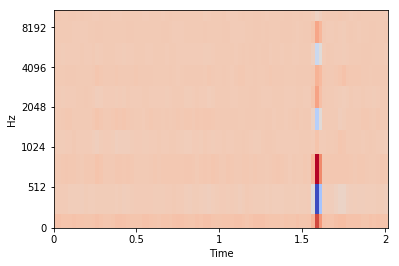

In [775]:
spec = load_mel(os.path.join(os.getcwd(), 'train','rec25.wav'),start=9, stop=10)
# spec = librosa.power_to_db(spec,ref=5.0)
librosa.display.specshow(spec, y_axis='mel', x_axis='time')

In [772]:
mfccs = librosa.feature.mfcc(S=spec, norm='ortho', dct_type=3)

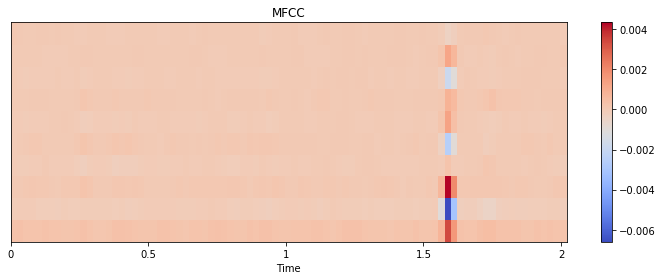

In [773]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [766]:
mfccs.shape

(10, 87)

In [476]:
spec.shape

(10, 87)

In [463]:
spec.shape

(10, 87)

In [776]:
# Poniższa linijka ustawia folder główny
# os.chdir('../input/')

X_test = load_test()
# np.save(os.path.join('test', 'tmp_X_test'), X_test)

X, y = load_train()
# np.save(os.path.join('train', 'tmp_X_train'), X)
# np.save(os.path.join('train', 'tmp_y_train'), y)

['rec204.wav', 'rec170.wav', 'rec18.wav', 'rec78.wav', 'rec183.wav', 'rec103.wav', 'rec246.wav', 'rec8.wav', 'rec88.wav', 'rec297.wav', 'rec222.wav', 'rec107.wav', 'rec209.wav', 'rec79.wav', 'rec312.wav', 'rec343.wav', 'rec87.wav', 'rec101.wav', 'rec291.wav', 'rec256.wav', 'rec272.wav', 'rec173.wav', 'rec133.wav', 'rec307.wav', 'rec276.wav', 'rec38.wav', 'rec323.wav', 'rec146.wav', 'rec81.wav', 'rec161.wav', 'rec185.wav', 'rec194.wav', 'rec28.wav', 'rec213.wav', 'rec47.wav', 'rec310.wav', 'rec334.wav', 'rec330.wav', 'rec339.wav', 'rec110.wav', 'rec6.wav', 'rec255.wav', 'rec15.wav', 'rec325.wav', 'rec232.wav', 'rec214.wav', 'rec340.wav', 'rec50.wav', 'rec273.wav', 'rec122.wav', 'rec200.wav', 'rec207.wav', 'rec54.wav', 'rec148.wav', 'rec106.wav', 'rec201.wav', 'rec120.wav', 'rec187.wav', 'rec189.wav', 'rec42.wav', 'rec174.wav', 'rec98.wav', 'rec167.wav', 'rec338.wav', 'rec316.wav', 'rec13.wav', 'rec248.wav', 'rec196.wav', 'rec157.wav', 'rec190.wav', 'rec169.wav', 'rec218.wav', 'rec90.wav

In [777]:
np.save(os.path.join('test', 'tmp_X_test'), X_test)
np.save(os.path.join('train', 'tmp_X_train'), X)
np.save(os.path.join('train', 'tmp_y_train'), y)

In [794]:
X_test = np.load(os.path.join(os.getcwd(), 'test', 'tmp_X_test.npy'))
X = np.load(os.path.join(os.getcwd(), 'train', 'tmp_X_train.npy'))
y = np.load(os.path.join(os.getcwd(), 'train', 'tmp_y_train.npy'))

In [782]:
y[521]

1

In [780]:
X.shape

(3589, 10, 87)

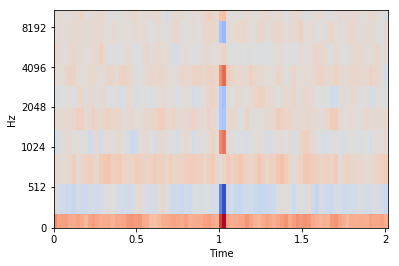

In [783]:
librosa.display.specshow(X[521], y_axis='mel', x_axis='time')


In [767]:
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(X[120]), n_mfcc=20, dct_type=3)


In [768]:
mfccs.shape

(10, 87)

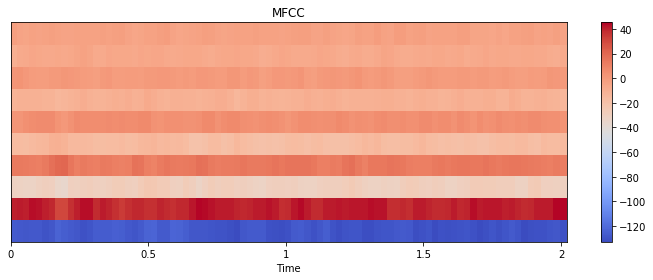

In [769]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

# Model i Trenowanie

Poniższy przykład używa poprawnych metryk i zapisuje parametry modelu.

In [550]:
# class Detector(torch.nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.linear = torch.nn.Linear(10 * 87, 2)
    
#     def forward(self, x):
#         out = torch.flatten(x, start_dim = 1)
#         out = self.linear(out)
#         return out
    
# clf = Detector()

In [825]:

X_test = np.load(os.path.join(os.getcwd(), 'test', 'tmp_X_test.npy'))
X = np.load(os.path.join(os.getcwd(), 'train', 'tmp_X_train.npy'))
y = np.load(os.path.join(os.getcwd(), 'train', 'tmp_y_train.npy'))

import torch
class ConvNet(torch.nn.Module):
    
    def __init__(self, block):
        super(ConvNet, self).__init__()
        
        # wstępna warstwa konwolucyjna + ReLU
        self.conv = torch.nn.Conv2d(1, 8, kernel_size=(1,10))
        self.relu = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(8)
        
        # (mikroarchitektura + max pooling) x 2
#         self.block1 = block(16, 32)
#         self.pool1 = torch.nn.MaxPool2d((1,10))
#         self.block2 = block(32, 64)
        self.pool2 = torch.nn.MaxPool2d((1,10))
        
        # warstwa w pełni połączona po "rozprostowaniu" obrazu do postaci wektora
        self.dense = torch.nn.Linear(560, 2)
    
    def forward(self, x):
        log = False 
        if log:
            print(x.shape)
        out = self.relu(self.batch_norm1(self.conv(x)))
        if log:
            print(out.shape)
#         out = self.block1(out)
#         if log:
#             print(out.shape)
#         out = self.pool1(out)
#         if log:
#             print(out.shape)
#         out = self.block2(out)
#         if log:
#             print(out.shape)
        out = self.pool2(out)
        if log:
            print(out.shape)
        out = out.view(out.size(0), -1)
        
        if log:
            print(out.shape)
        return self.dense(out)
    
class BaseBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(BaseBlock, self).__init__()
        if not hidden_channels:
            hidden_channels = out_channels

        # konwolucja zawiera padding=1, aby nie zmniejszać rozmiaru obrazu
        self.conv1 = torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=(1,10))
        # istnieje wersja batch normalization dla obrazów - statystyki dla filtrów
        self.batch_norm1 = torch.nn.BatchNorm2d(hidden_channels)
        # nieliniowość ReLU
        self.relu1 = torch.nn.ReLU()

        # drugi raz te same warstwy
        self.conv2 = torch.nn.Conv2d(hidden_channels, out_channels, kernel_size=(2,2))
        self.batch_norm2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU()

    def forward(self, x):
        out = self.relu1(self.batch_norm1(self.conv1(x)))
        out = self.relu2(self.batch_norm2(self.conv2(out)))
        return out   

class ResNetBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(ResNetBlock, self).__init__()
        if not hidden_channels:
            hidden_channels = out_channels
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.batch_norm1 = torch.nn.BatchNorm2d(hidden_channels) 
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.batch_norm2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU()

    
    def forward(self, x):
        out = self.relu1(self.batch_norm1(self.conv1(x)))
        out = self.conv2(out)
        if self.in_channels < self.out_channels:
            x = self.conv3(x)
        out = torch.add(x, out)
        out = self.relu2(self.batch_norm2(out))
        return out


clf = ConvNet(BaseBlock)

# Dzielenie zbioru danych na treningowy i walidacyjny
split_point = int(len(X) * 0.5)

X_train = torch.Tensor(X[:split_point]).unsqueeze(1)
y_train = torch.LongTensor(y[:split_point])

X_valid = torch.Tensor(X[split_point:]).unsqueeze(1)
y_valid = torch.LongTensor(y[split_point:])

batch_size = 32 

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

# Ustawienie kosztu i optimizera
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters())

# Pętla uczenia
best_preds, best_score = None, 0.
losses, scores = [], []
epochs_number = 100 
for epoch in trange(epochs_number):
    running_loss = 0
    clf.train()
    for X, y in data_loader:
        optimizer.zero_grad()

        outputs = clf(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    losses.append(running_loss)
    
    clf.eval()
    preds = []
    for X, _ in valid_data_loader:
        out = clf(X)
        preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
    preds = np.concatenate(preds, axis = 0)
    
    # Metryką testującą jest ROC AUC
    score = roc_auc_score(y_valid.numpy(), preds)
    scores.append(score)
    print(score)
    if score > best_score:
        best_score = score
        best_preds = preds
        np.save('tmp_preds', best_preds)
        # Model dający najlepszy wynik powinien być zapisany
torch.save(clf.state_dict(), 'tmp_model.pt')






  0%|          | 0/100 [00:00<?, ?it/s]




  1%|          | 1/100 [00:00<01:16,  1.29it/s]

0.329291641723







  2%|▏         | 2/100 [00:01<01:16,  1.29it/s]

0.298389344178







  3%|▎         | 3/100 [00:02<01:15,  1.29it/s]

0.351398808909







  4%|▍         | 4/100 [00:03<01:12,  1.32it/s]

0.359590136862







  5%|▌         | 5/100 [00:03<01:11,  1.32it/s]

0.422988099416







  6%|▌         | 6/100 [00:04<01:14,  1.26it/s]

0.425054961501







  7%|▋         | 7/100 [00:05<01:15,  1.23it/s]

0.519138472019







  8%|▊         | 8/100 [00:06<01:16,  1.20it/s]

0.492971120699







  9%|▉         | 9/100 [00:07<01:16,  1.18it/s]

0.465234915261







 10%|█         | 10/100 [00:08<01:17,  1.16it/s]

0.570602305803







 11%|█         | 11/100 [00:09<01:16,  1.17it/s]

0.619883161654







 12%|█▏        | 12/100 [00:09<01:14,  1.19it/s]

0.629943954751







 13%|█▎        | 13/100 [00:10<01:13,  1.19it/s]

0.552737237578







 14%|█▍        | 14/100 [00:11<01:11,  1.20it/s]

0.712854540388







 15%|█▌        | 15/100 [00:12<01:10,  1.20it/s]

0.658143333402







 16%|█▌        | 16/100 [00:13<01:08,  1.23it/s]

0.642600582127







 17%|█▋        | 17/100 [00:13<01:06,  1.24it/s]

0.796672119811







 18%|█▊        | 18/100 [00:14<01:05,  1.24it/s]

0.583071857647







 19%|█▉        | 19/100 [00:15<01:04,  1.25it/s]

0.715658093017







 20%|██        | 20/100 [00:16<01:03,  1.26it/s]

0.604006254774







 21%|██        | 21/100 [00:17<01:07,  1.18it/s]

0.783923889932







 22%|██▏       | 22/100 [00:18<01:05,  1.19it/s]

0.693944429536







 23%|██▎       | 23/100 [00:18<01:04,  1.19it/s]

0.755601944553







 24%|██▍       | 24/100 [00:19<01:03,  1.19it/s]

0.817149794604







 25%|██▌       | 25/100 [00:20<01:03,  1.19it/s]

0.659979253969







 26%|██▌       | 26/100 [00:21<01:02,  1.19it/s]

0.699314142394







 27%|██▋       | 27/100 [00:22<01:01,  1.19it/s]

0.74348461078







 28%|██▊       | 28/100 [00:23<01:00,  1.19it/s]

0.729971306484







 29%|██▉       | 29/100 [00:23<00:59,  1.19it/s]

0.777617509238







 30%|███       | 30/100 [00:24<00:57,  1.22it/s]

0.747857017526







 31%|███       | 31/100 [00:25<00:57,  1.20it/s]

0.737561412382







 32%|███▏      | 32/100 [00:26<00:57,  1.19it/s]

0.784270947299







 33%|███▎      | 33/100 [00:27<00:55,  1.20it/s]

0.749282662098







 34%|███▍      | 34/100 [00:28<00:54,  1.20it/s]

0.791321759594







 35%|███▌      | 35/100 [00:28<00:53,  1.21it/s]

0.813934675805







 36%|███▌      | 36/100 [00:29<00:52,  1.22it/s]

0.716003860207







 37%|███▋      | 37/100 [00:30<00:51,  1.21it/s]

0.728679840225







 38%|███▊      | 38/100 [00:31<00:51,  1.21it/s]

0.70300146564







 39%|███▉      | 39/100 [00:32<00:50,  1.20it/s]

0.741551927007







 40%|████      | 40/100 [00:33<00:50,  1.19it/s]

0.809924808538







 41%|████      | 41/100 [00:33<00:48,  1.22it/s]

0.755371003034







 42%|████▏     | 42/100 [00:34<00:47,  1.21it/s]

0.731261482567







 43%|████▎     | 43/100 [00:35<00:46,  1.21it/s]

0.776058976529







 44%|████▍     | 44/100 [00:36<00:45,  1.24it/s]

0.780853270854







 45%|████▌     | 45/100 [00:37<00:44,  1.25it/s]

0.689494612225







 46%|████▌     | 46/100 [00:37<00:42,  1.27it/s]

0.779906281609







 47%|████▋     | 47/100 [00:38<00:41,  1.27it/s]

0.699325753979







 48%|████▊     | 48/100 [00:39<00:41,  1.25it/s]

0.793551183866







 49%|████▉     | 49/100 [00:40<00:40,  1.25it/s]

0.756628924716







 50%|█████     | 50/100 [00:41<00:40,  1.25it/s]

0.694039902566







 51%|█████     | 51/100 [00:41<00:39,  1.24it/s]

0.734799145387







 52%|█████▏    | 52/100 [00:42<00:39,  1.22it/s]

0.780450735916







 53%|█████▎    | 53/100 [00:43<00:41,  1.12it/s]

0.74218024276







 54%|█████▍    | 54/100 [00:44<00:40,  1.15it/s]

0.747060978882







 55%|█████▌    | 55/100 [00:45<00:37,  1.19it/s]

0.791107590364







 56%|█████▌    | 56/100 [00:46<00:34,  1.26it/s]

0.721789009764







 57%|█████▋    | 57/100 [00:46<00:32,  1.33it/s]

0.809448733563







 58%|█████▊    | 58/100 [00:47<00:30,  1.39it/s]

0.766809704188







 59%|█████▉    | 59/100 [00:48<00:28,  1.42it/s]

0.811536238466







 60%|██████    | 60/100 [00:48<00:30,  1.32it/s]

0.784107094936







 61%|██████    | 61/100 [00:49<00:29,  1.34it/s]

0.823825165659







 62%|██████▏   | 62/100 [00:50<00:29,  1.28it/s]

0.721574840534







 63%|██████▎   | 63/100 [00:51<00:29,  1.24it/s]

0.792662252544







 64%|██████▍   | 64/100 [00:52<00:29,  1.20it/s]

0.799555663357







 65%|██████▌   | 65/100 [00:53<00:29,  1.20it/s]

0.797261730281







 66%|██████▌   | 66/100 [00:53<00:28,  1.19it/s]

0.710374821956







 67%|██████▋   | 67/100 [00:54<00:28,  1.17it/s]

0.732160735297







 68%|██████▊   | 68/100 [00:55<00:26,  1.20it/s]

0.726294304647







 69%|██████▉   | 69/100 [00:56<00:25,  1.21it/s]

0.803422321078







 70%|███████   | 70/100 [00:57<00:24,  1.23it/s]

0.810222839213







 71%|███████   | 71/100 [00:58<00:23,  1.23it/s]

0.762961108932







 72%|███████▏  | 72/100 [00:58<00:23,  1.19it/s]

0.759717606259







 73%|███████▎  | 73/100 [00:59<00:22,  1.20it/s]

0.813765662738







 74%|███████▍  | 74/100 [01:00<00:21,  1.21it/s]

0.808564962946







 75%|███████▌  | 75/100 [01:01<00:20,  1.22it/s]

0.778444512107







 76%|███████▌  | 76/100 [01:02<00:19,  1.24it/s]

0.81544805235







 77%|███████▋  | 77/100 [01:02<00:18,  1.25it/s]

0.797843599694







 78%|███████▊  | 78/100 [01:03<00:18,  1.22it/s]

0.659805080197







 79%|███████▉  | 79/100 [01:04<00:17,  1.21it/s]

0.754369826394







 80%|████████  | 80/100 [01:05<00:16,  1.21it/s]

0.780769409409







 81%|████████  | 81/100 [01:06<00:15,  1.21it/s]

0.710220000826







 82%|████████▏ | 82/100 [01:07<00:14,  1.23it/s]

0.756559255207







 83%|████████▎ | 83/100 [01:07<00:13,  1.25it/s]

0.830971450984







 84%|████████▍ | 84/100 [01:08<00:12,  1.24it/s]

0.801999256859







 85%|████████▌ | 85/100 [01:09<00:12,  1.22it/s]

0.789012344405







 86%|████████▌ | 86/100 [01:10<00:11,  1.20it/s]

0.782775633218







 87%|████████▋ | 87/100 [01:11<00:11,  1.18it/s]

0.82285624342







 88%|████████▊ | 88/100 [01:12<00:10,  1.18it/s]

0.825788813657







 89%|████████▉ | 89/100 [01:12<00:09,  1.19it/s]

0.773504427884







 90%|█████████ | 90/100 [01:13<00:08,  1.22it/s]

0.811131123176







 91%|█████████ | 91/100 [01:14<00:07,  1.24it/s]

0.806440042937







 92%|█████████▏| 92/100 [01:15<00:06,  1.25it/s]

0.790795367752







 93%|█████████▎| 93/100 [01:16<00:05,  1.25it/s]

0.800275581611







 94%|█████████▍| 94/100 [01:16<00:04,  1.26it/s]

0.759371839069







 95%|█████████▌| 95/100 [01:17<00:03,  1.27it/s]

0.820251377908







 96%|█████████▌| 96/100 [01:18<00:03,  1.26it/s]

0.731436946514







 97%|█████████▋| 97/100 [01:19<00:02,  1.27it/s]

0.809346809653







 98%|█████████▊| 98/100 [01:19<00:01,  1.27it/s]

0.809815143571







 99%|█████████▉| 99/100 [01:20<00:00,  1.28it/s]

0.77904960469







100%|██████████| 100/100 [01:21<00:00,  1.28it/s]

0.803777119501


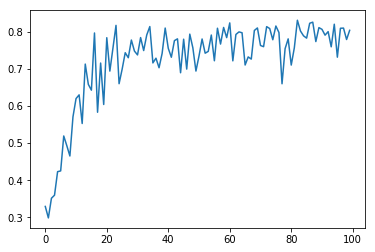

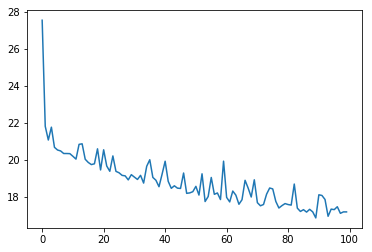

In [826]:
# Rysowanie lossu i AUC

import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()

# Zapis Predykcji

In [815]:
def save_predictions(preds):
    '''Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    '''
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for pred, line in zip(preds, lines):
        output_lines.append("{},{}".format(line.split(',')[0], pred))
    
    with open('submission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')

In [816]:
# Wczytanie najlepszego modelu
clf.load_state_dict(torch.load('tmp_model.pt'))

# Tworzenie data loadera testowego
X_test_tensor = torch.Tensor(X_test).unsqueeze(1)

test_dataset = TensorDataset(X_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)

# Ewaluacja modelu na danych testowych
clf.eval()
preds = []
for X in test_data_loader:
    out = clf(X[0])
    preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
preds = np.concatenate(preds, axis = 0)


In [817]:


# Zapisanie predykcji do poprawnego formatu
save_predictions(preds)